In [1]:
# Get the data for expeirment
import pandas as pd 
import numpy as np

from sklearn.preprocessing import StandardScaler

import GprModel

import matplotlib.ticker as ticker

import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [3]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/solar_x_train.csv')
x_test = pd.read_csv('Data/FES/solar_x_test.csv')
y_train = pd.read_csv('Data/FES/solar_y_train.csv')
y_test = pd.read_csv('Data/FES/solar_y_test.csv')

In [14]:

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    target_scaler = StandardScaler()  
    scaled_train_y = target_scaler.fit_transform(train_y)
    scaled_test_y = target_scaler.transform(test_y)    
    
    return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(50, activation=keras.activations.tanh))    
    model.add(layers.Dense(5, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [10]:
x_train, x_test, y_train, y_test, feature_scaler, target_scaler = preprocess_data(x_train, x_test, y_train, y_test)

In [15]:
neural_network_model = build_neural_network_model()

neural_network_model.compile(
    optimizer='adam',
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsolutePercentageError()]
)

history = neural_network_model.fit(
    x_train, 
    y_train, 
    epochs=50, 
    shuffle=True
)

Epoch 1/50


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6849 - mean_absolute_percentage_error: 96.4408 - root_mean_squared_error: 0.8207
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3791 - mean_absolute_percentage_error: 75.2904 - root_mean_squared_error: 0.6151
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3546 - mean_absolute_percentage_error: 71.5562 - root_mean_squared_error: 0.5953
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3549 - mean_absolute_percentage_error: 72.4305 - root_mean_squared_error: 0.5956
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3617 - mean_absolute_percentage_error: 72.2302 - root_mean_squared_error: 0.6012
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3576 - mean_absolute_percentage_error: 72.3492 - root_mean_squared_error: 0.5979
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3396 - mean_absolute_percentage_error: 70.6804 - root_mean_squared_error: 0.5825
Epoch 8/50
70/70 ━━━━━━━

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3996 - mean_absolute_percentage_error: 78.8998 - root_mean_squared_error: 0.6322

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2475 - mean_absolute_percentage_error: 94.6142 - root_mean_squared_error: 2.1749


[3.483288049697876, 102.71862030029297, 1.8768808841705322]

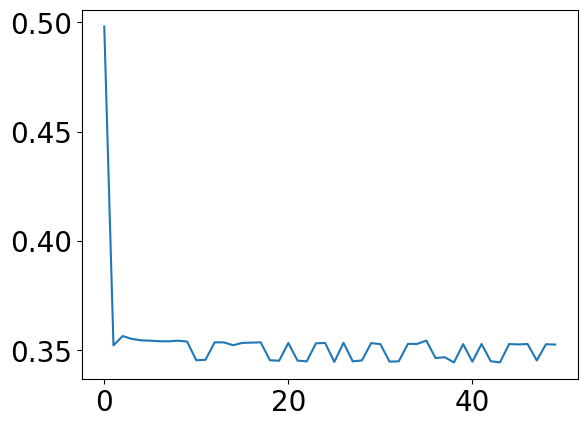

In [17]:
plt.plot(history.history['loss'])
neural_network_model.evaluate(x_test, y_test)